# <center> <span style='color:Blue'>---LAB-4: denoising by spectral substraction---</span> <center>

<span style='color:Red'>I-Import libraries and audios</span>
=======

Used libraries:
[librosa](https://librosa.org/doc/latest/index.html), [numpy](https://numpy.org/), [ipython](https://ipython.org/), [scipy](https://www.scipy.org/),[matplotlib](https://matplotlib.org/)

In [47]:
%matplotlib inline
import librosa
from IPython.display import Audio
import scipy
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams.update({'font.size': 12})

In [48]:
file_path_music = "../data/audios/music.wav" # import audio
audio , audio_rate = librosa.load(file_path_music, sr=None, mono = True, 
                                                  offset = 0.0, duration = None)
print("Audio",[len(audio),audio_rate])



Audio [140001, 16000]


In [49]:
duration_of_sound = len(audio)/audio_rate
 
print(duration_of_sound,"s")

8.7500625 s


In [50]:
print("Original audio")
Audio(file_path_music)

Original audio


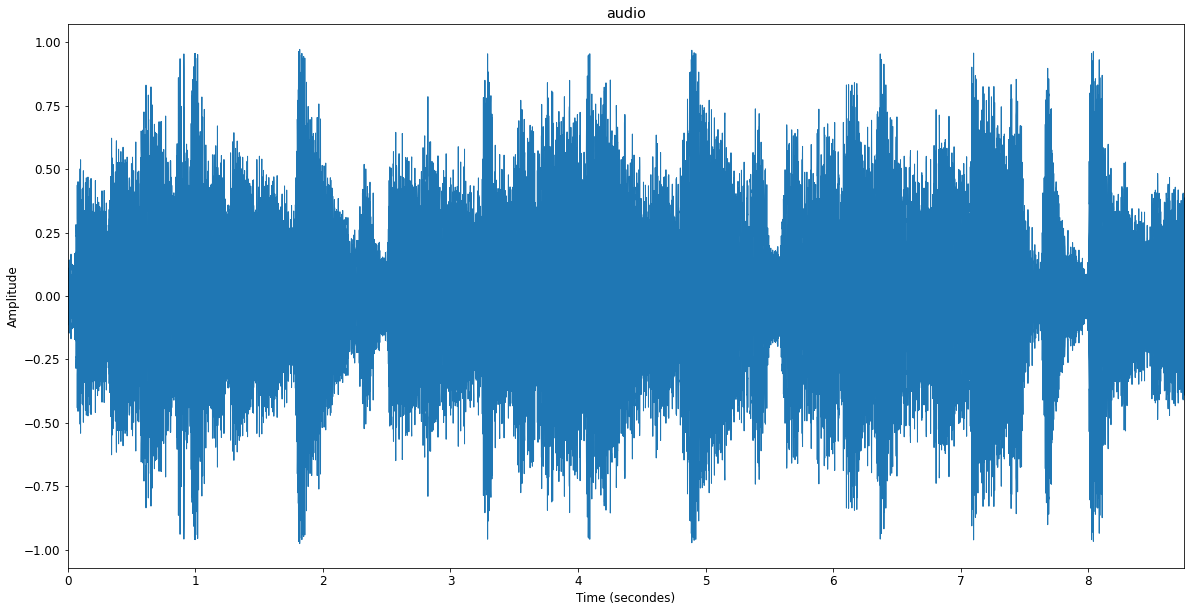

In [51]:
    librosa.display.waveplot(y = audio, sr = audio_rate) 
    plt.xlabel("Time (secondes)")
    plt.ylabel("Amplitude")
    plt.title("audio") 
plt.show()

In [52]:
file_path = ["../data/audios/noise1.wav", "../data/audios/noise2.wav", "../data/audios/noise3.wav"] 
noise = []
noise_rate = [] 

for i in range(3):
    samples_temp , sampling_rate_temp = librosa.load(file_path[i], sr=None, mono = True, 
                                                  offset = 0.0, duration = None)
    noise.append(samples_temp)
    noise_rate.append(sampling_rate_temp)
for i in range(3):
    print("Noise",i,[len(noise[i]),noise_rate[i]])

Noise 0 [140001, 16000]
Noise 1 [140001, 16000]
Noise 2 [140001, 16000]


In [53]:
duration_of_sound = [ len(noise[i])/noise_rate[i] for i in range(3) ]
duration_of_sound

[8.7500625, 8.7500625, 8.7500625]

In [54]:
print("Noise 1")
Audio(file_path[0])

Noise 1


In [55]:
print("Noise 2")
Audio(file_path[1])

Noise 2


In [56]:
print("Noise 3")
Audio(file_path[2])

Noise 3


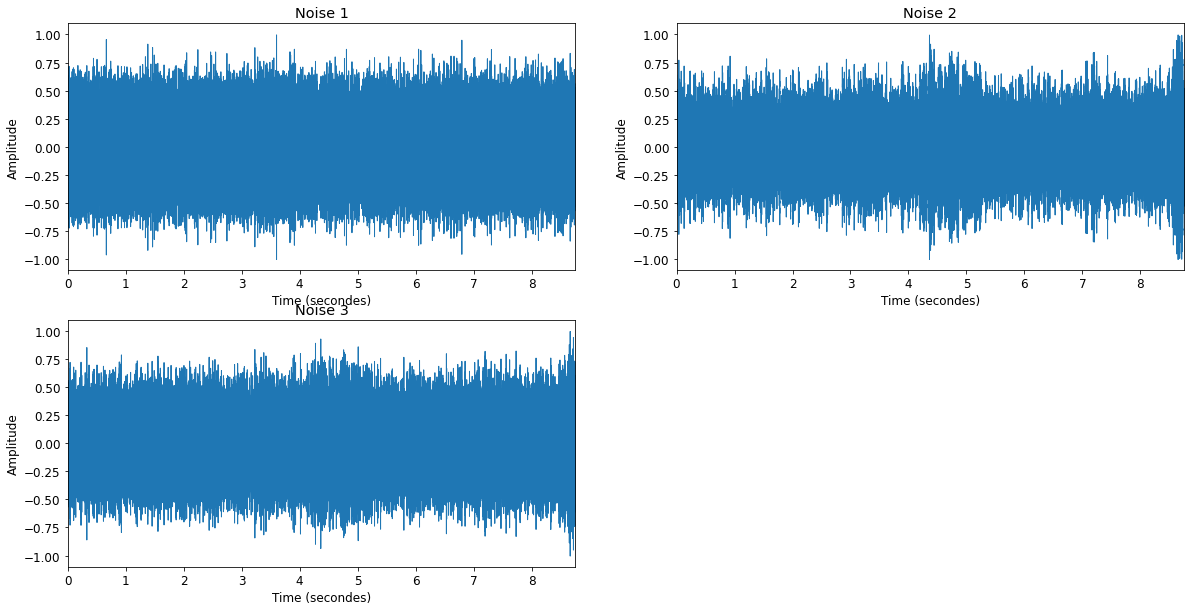

In [57]:
for i in range(3):
    plt.subplot(2, 2, i+1)
    
    librosa.display.waveplot(y = noise[i], sr = noise_rate[i]) 
    plt.xlabel("Time (secondes)")
    plt.ylabel("Amplitude")
    plt.title("Noise %i" %(i+1)) 
plt.show()

<span style='color:Red'>II-Noisy version of the music at various SNR Level</span>
=======

<b>Signal-to-noise ratio</b>  generically means the dimensionless ratio of the signal power to the noise power contained in a recording. Abbreviated SNR by engineers and scientists, the signal-to-noise ratio parameterizes the performance of optimal signal processing systems when the noise is Gaussian. 

Calculate the Sinal-to-Noise ratio

$$
S N R_{d B}=20 \log _{10} \frac{A_{\text {signal}}}{A_{\text {noise}}}
$$

$A_{signal}$ and $A_{noise}$ represent the "magnitude" or "strength" of voice and noise, respectively.

we need to calculate the RMS value of the signal and the provided noise. Then we modify the noise so the resulting noise would have the required RMS value that would give us the desired SNR.

In [60]:
def targetnoise(audio,noise, SNR):
    # scale the noise to target at a desired SNR level
    RMS_s=np.sqrt(np.mean(audio**2))
    #required RMS of noise
    RMS_n=np.sqrt(RMS_s**2/(pow(10,SNR/10)))
    #current RMS of noise
    RMS_n_current=np.sqrt(np.mean(noise**2))
    noise=noise*(RMS_n/RMS_n_current)
    return noise

In [61]:
def addnoise(audio, noise, SNR):   
    # scale the noise to target at a desired SNR level
    noise = targetnoise(audio,noise, SNR)
    # generate the mixture signal
    noisy = audio + noise;
    return noisy

                                                   SNR -50 dB


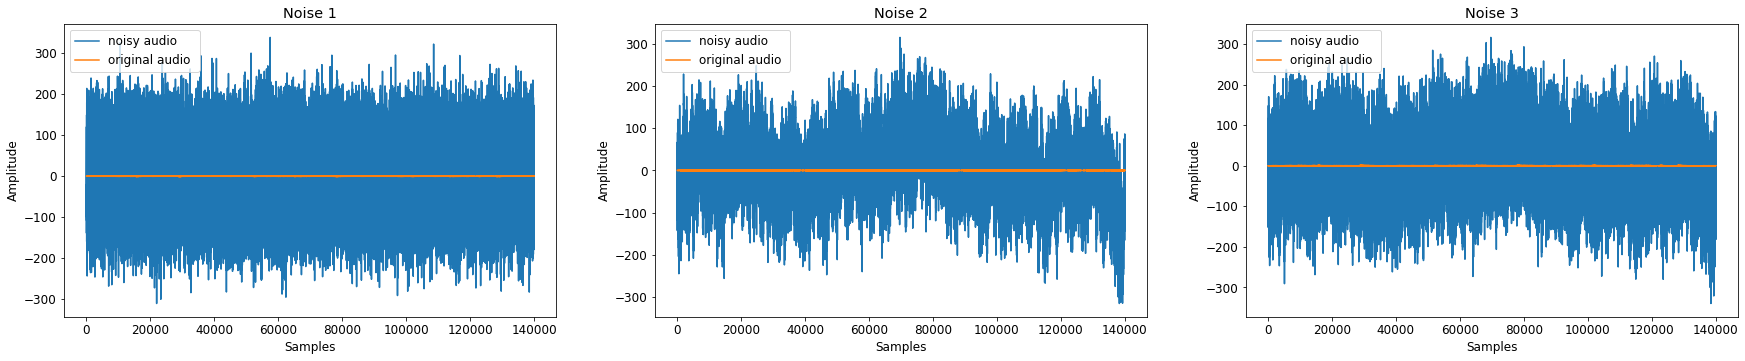

                                                   SNR -45 dB


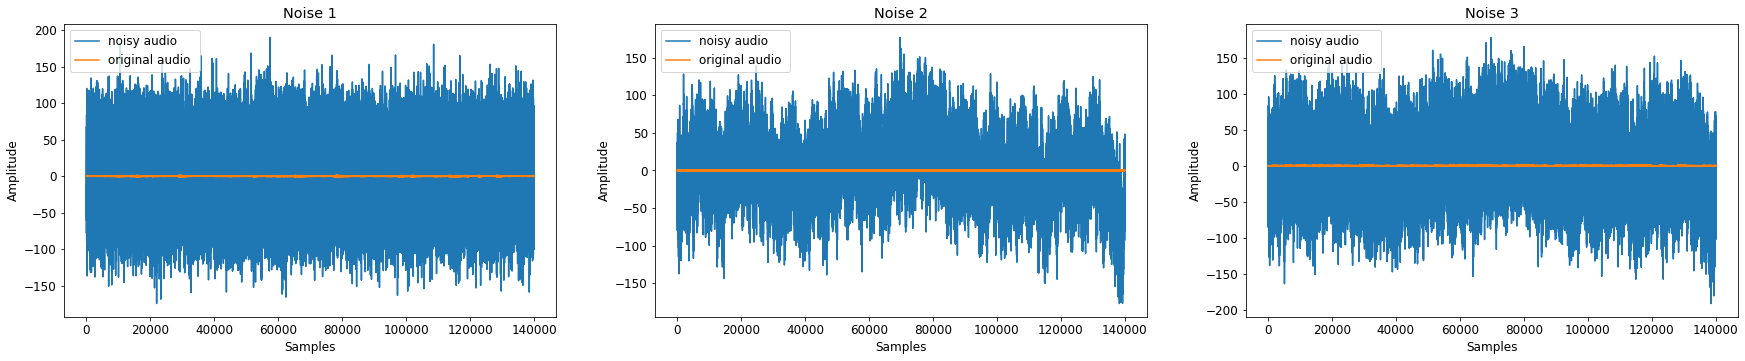

                                                   SNR -40 dB


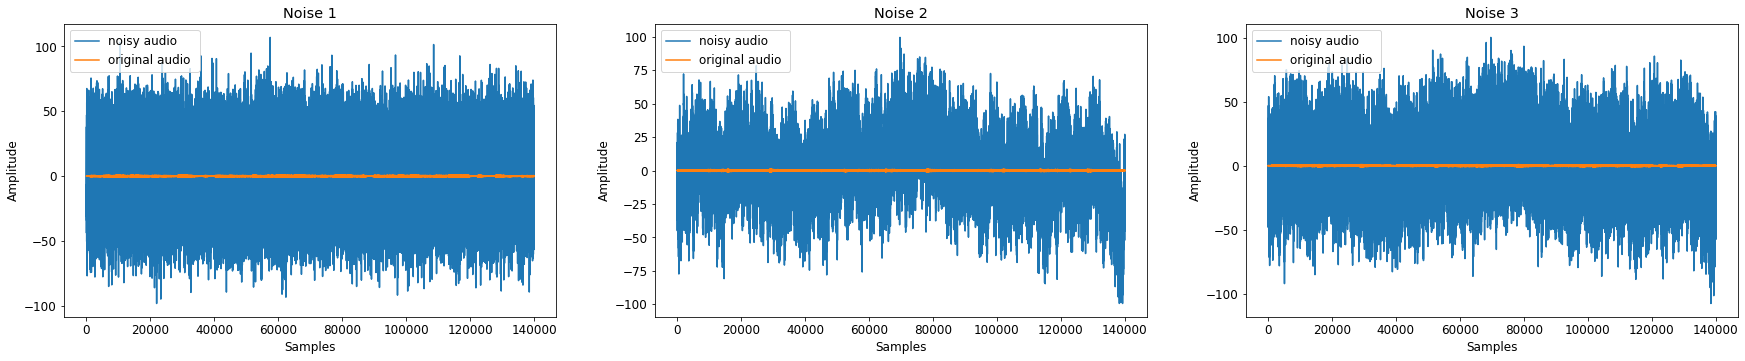

                                                   SNR -35 dB


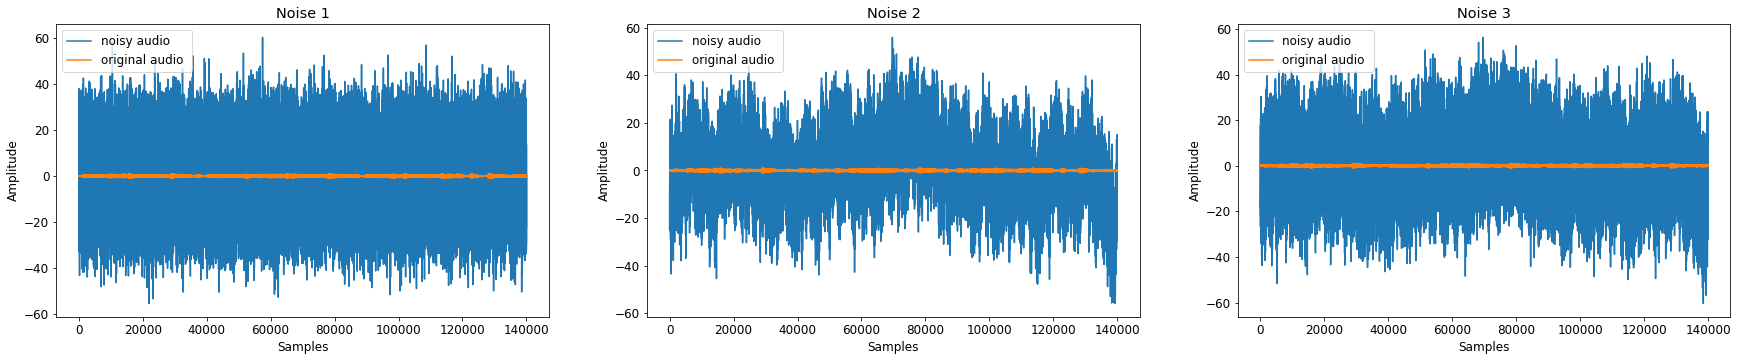

                                                   SNR -30 dB


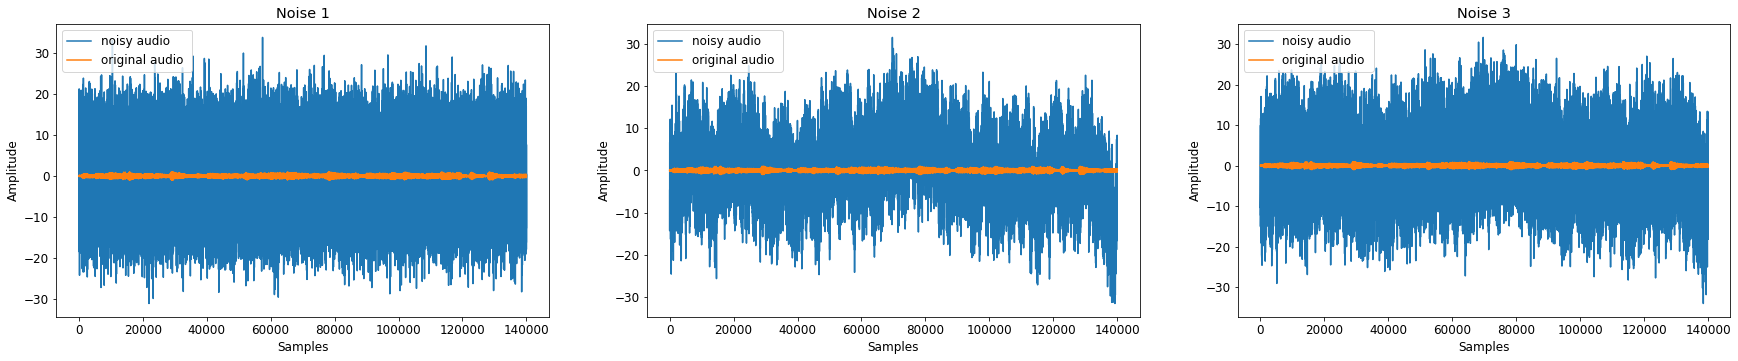

                                                   SNR -25 dB


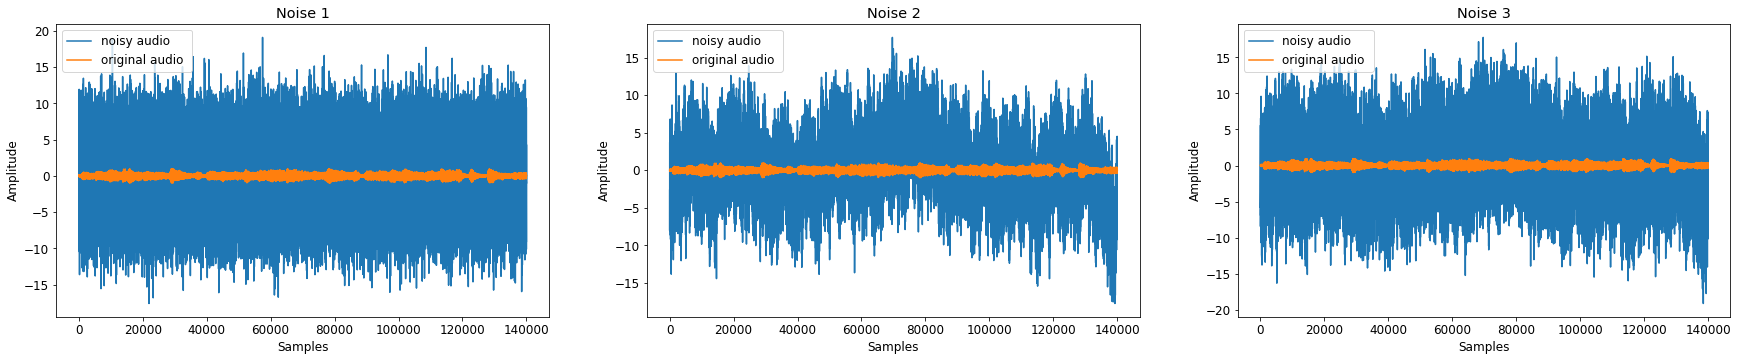

                                                   SNR -20 dB


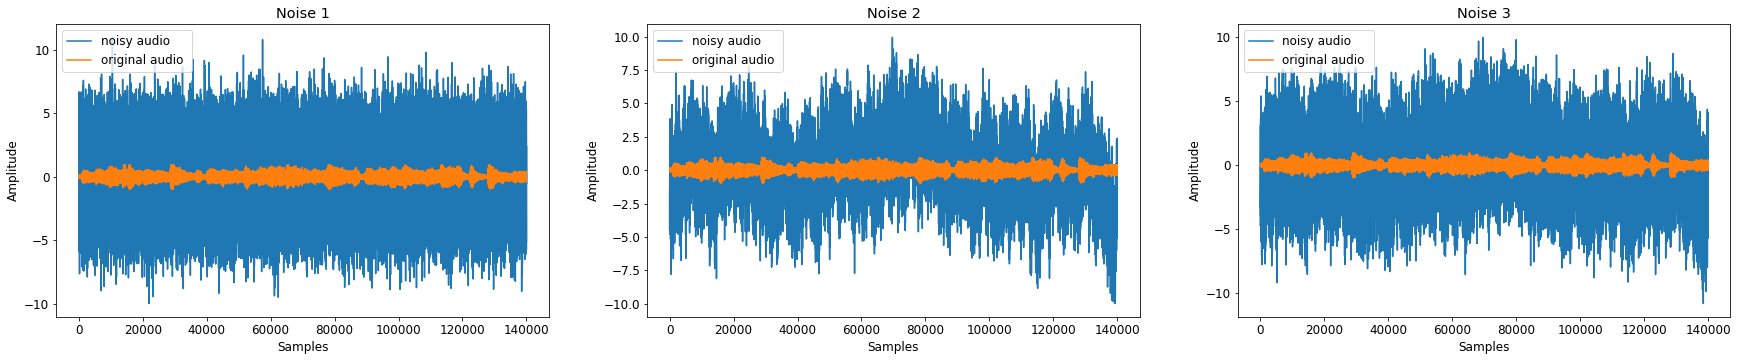

                                                   SNR -15 dB


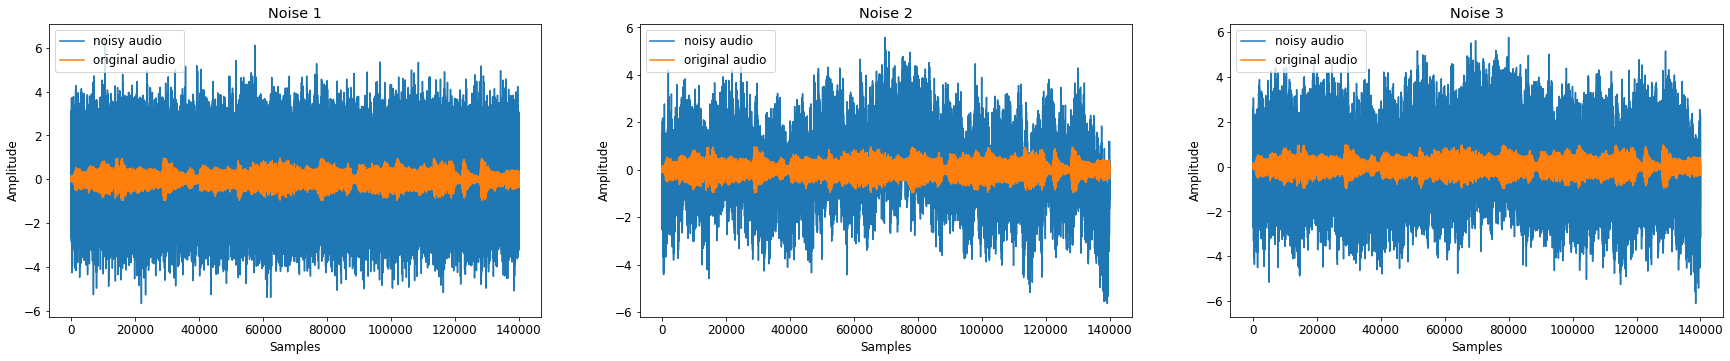

                                                   SNR -10 dB


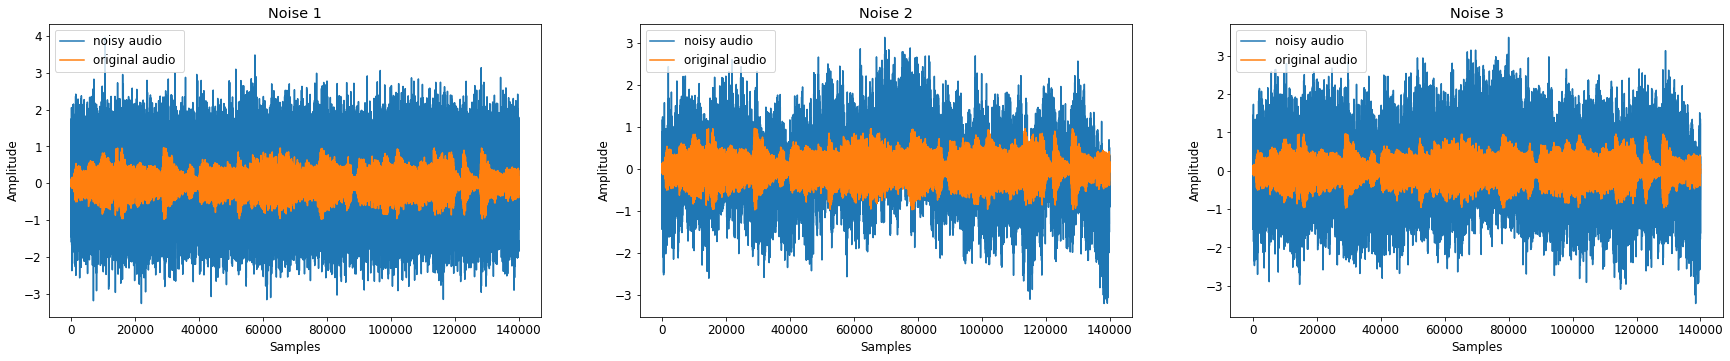

                                                   SNR -5 dB


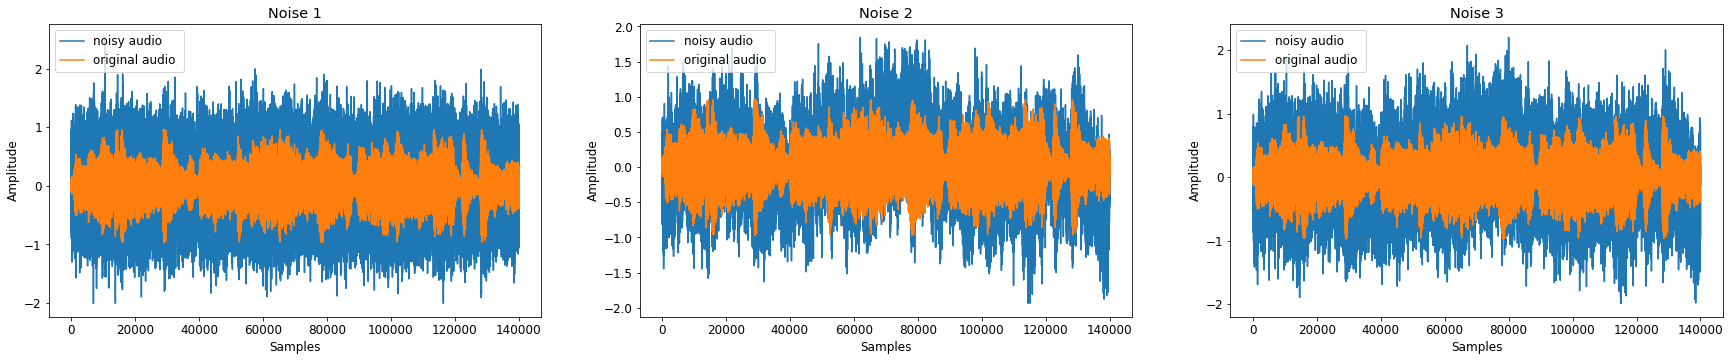

                                                   SNR 0 dB


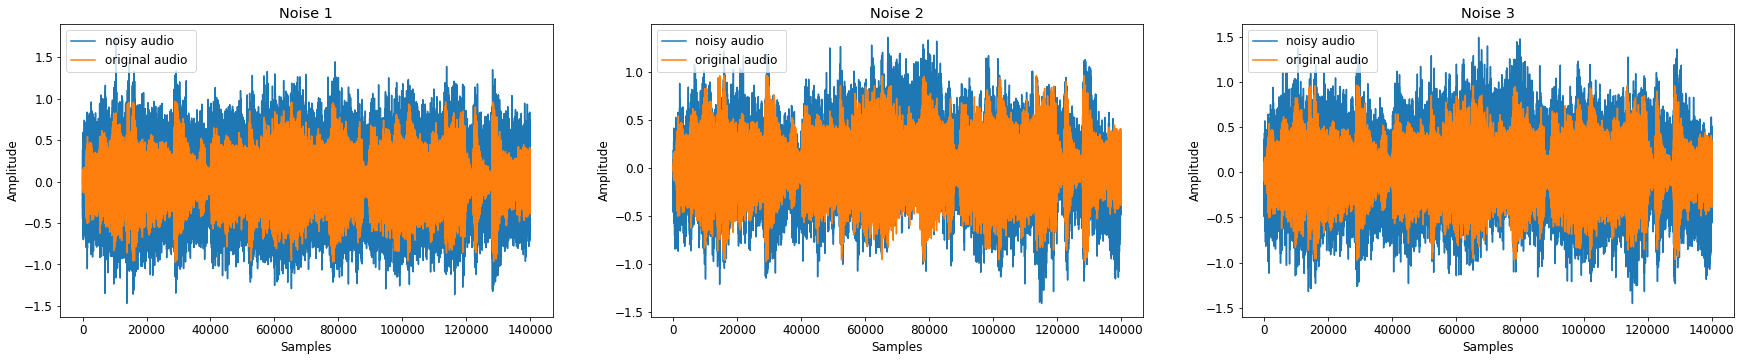

                                                   SNR 5 dB


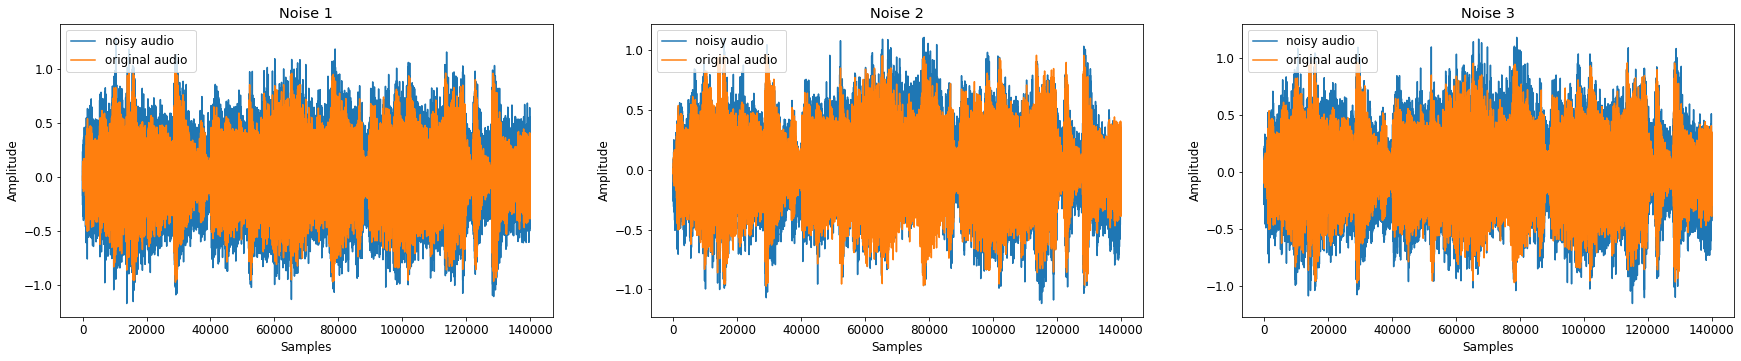

                                                   SNR 10 dB


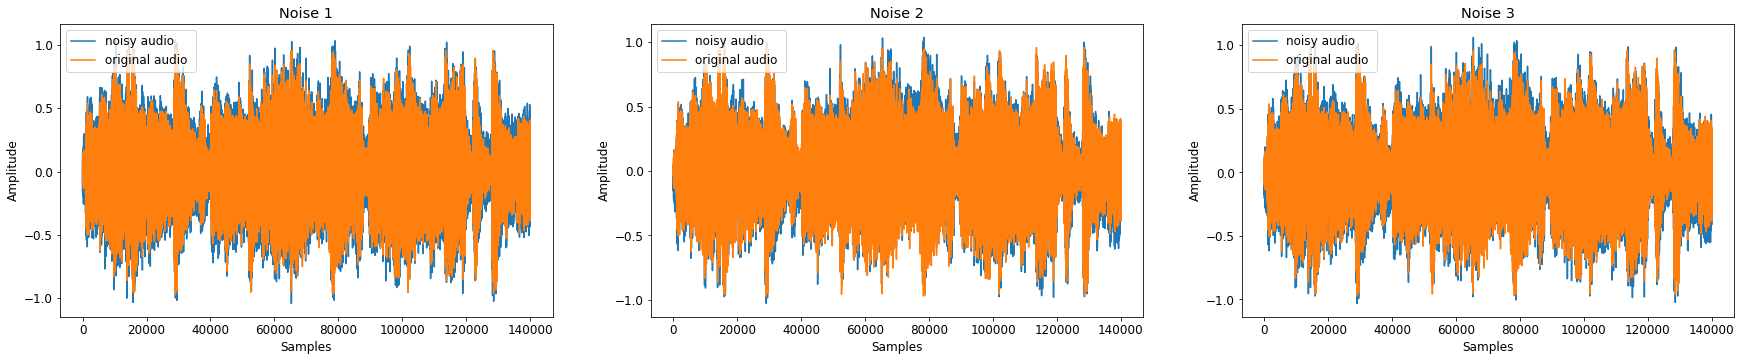

                                                   SNR 15 dB


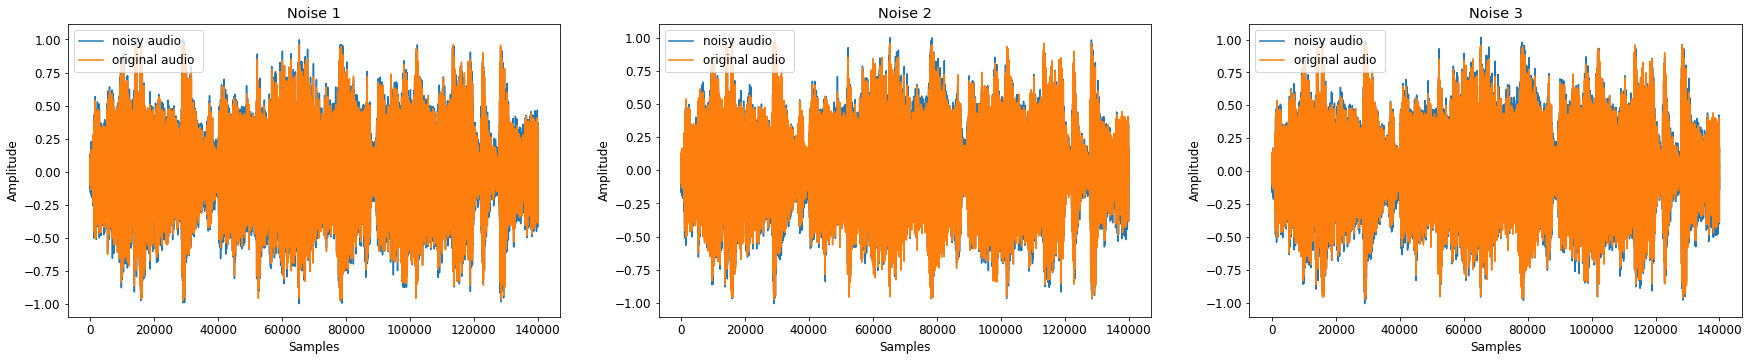

                                                   SNR 20 dB


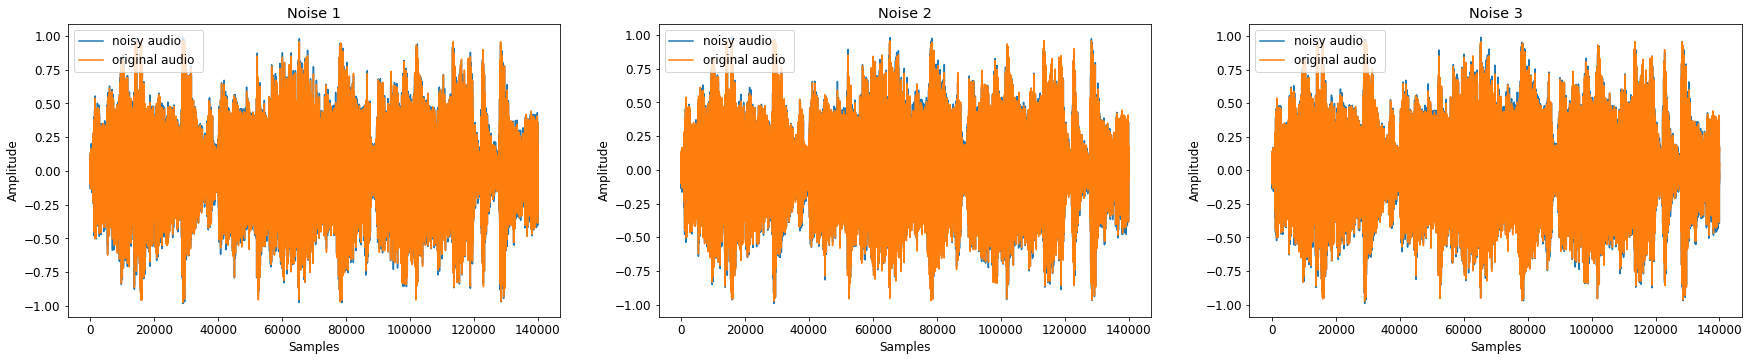

                                                   SNR 25 dB


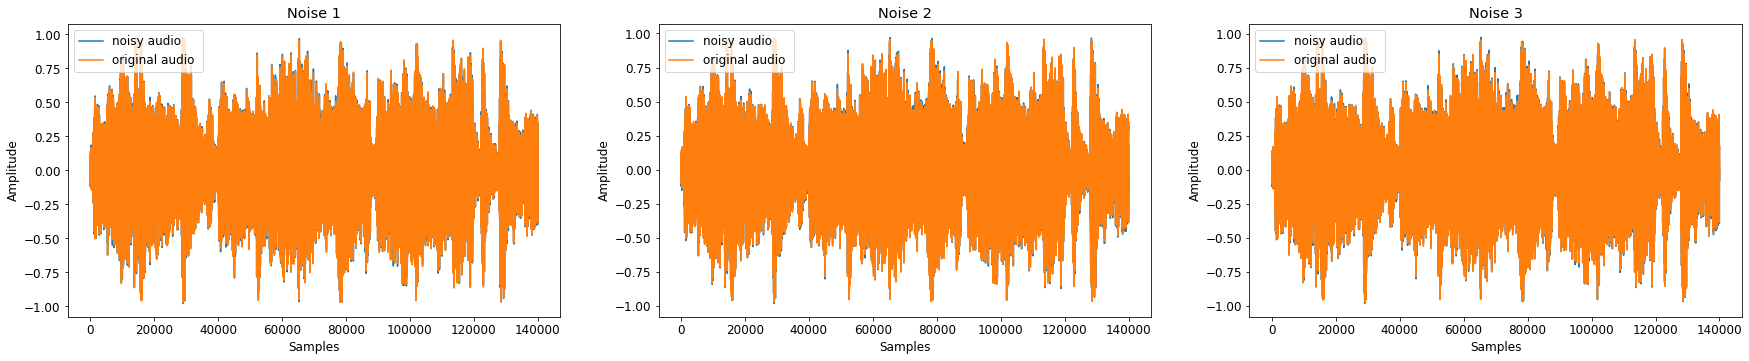

                                                   SNR 30 dB


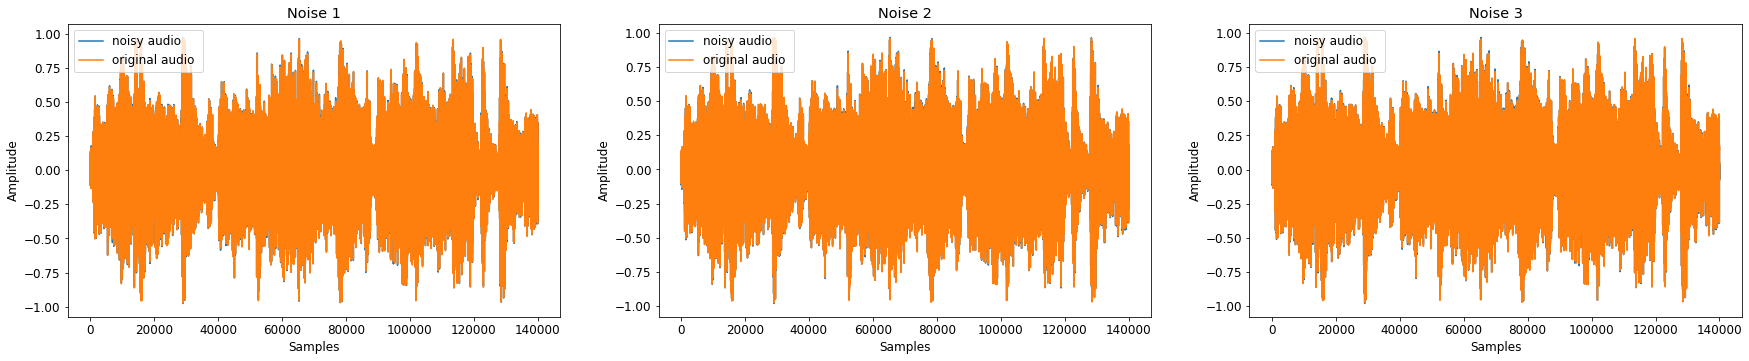

                                                   SNR 35 dB


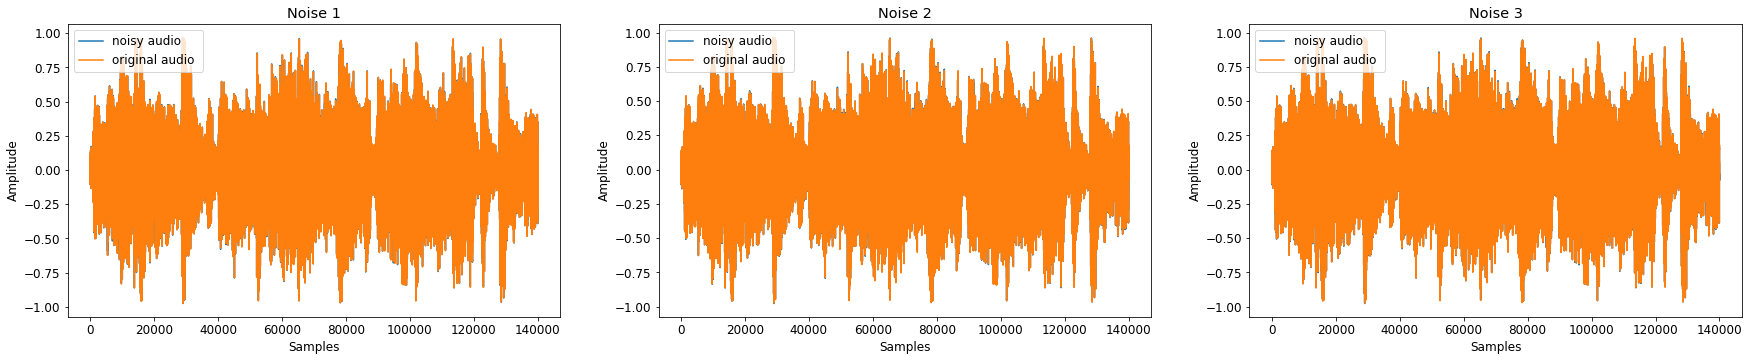

                                                   SNR 40 dB


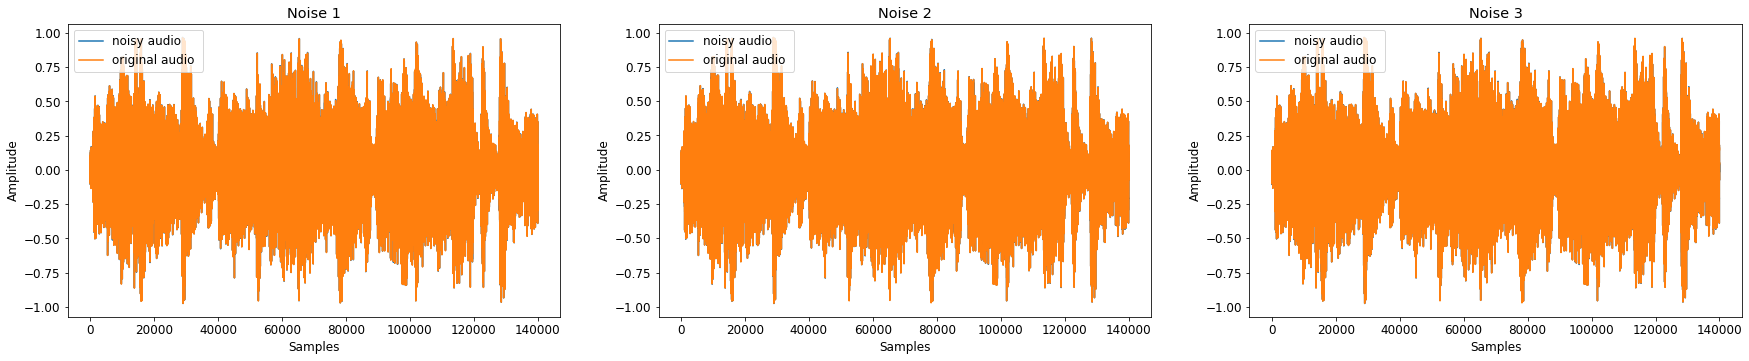

                                                   SNR 45 dB


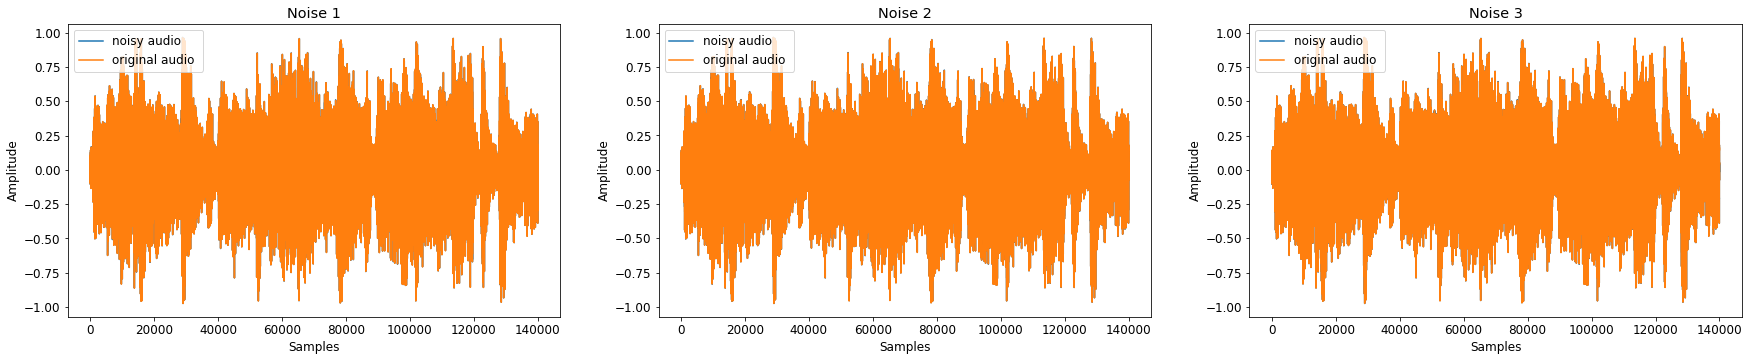

                                                   SNR 50 dB


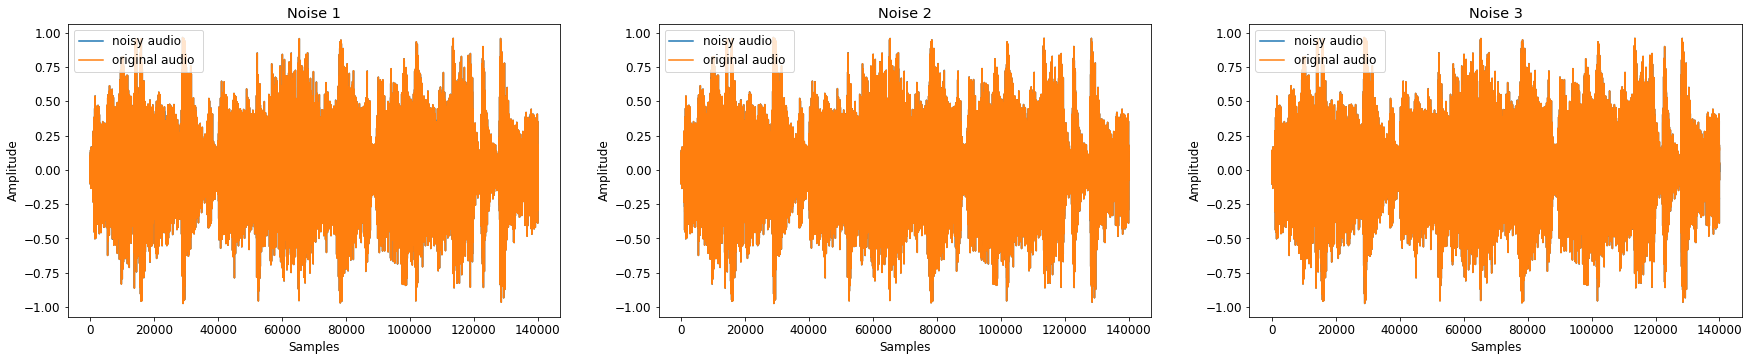

In [65]:
plt.rcParams['figure.figsize'] = [30, 70]
plt.rcParams.update({'font.size': 12})
noisy = []
space=' ';
d_snr=[x*5 for x in range(-10,11)]
for j in range(len(d_snr)):
    print(50*space,"SNR",d_snr[j],"dB")
    for i in range(3):
        noisy.append(addnoise(audio, noise[i],d_snr[j]))
        plt.subplot(11, 3, i+1)
        plt.plot(addnoise(audio, noise[i],d_snr[j]), label='noisy audio ')
        plt.plot(audio, label='original audio ')
        plt.xlabel("Samples")
        plt.ylabel("Amplitude")
        plt.title("Noise %i" %(i+1)) 
        plt.legend(loc="upper left")
    plt.show()

<span style='color:Red'>III-The spectral substraction method for denoising</span>
=======

We take the example of noise 1 with a $SNR=5 dB$

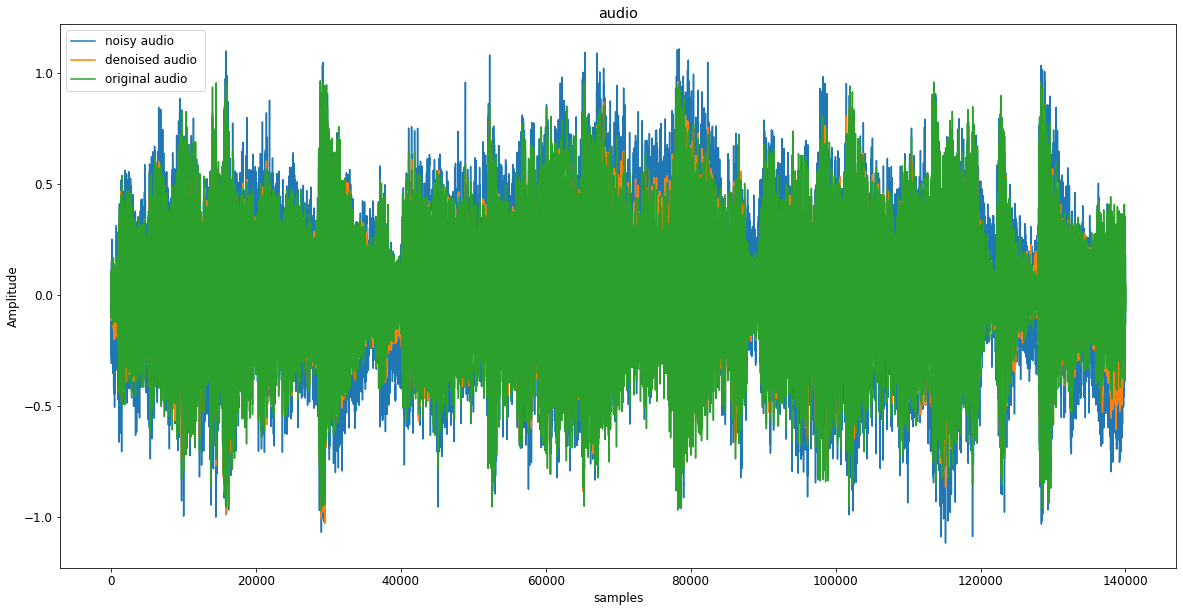

In [64]:
plt.rcParams['figure.figsize'] = [20, 10]
noised = addnoise(audio,noise[1],5)
s= librosa.stft(noised) # Short-time Fourier transform
ss= np.abs(s)         # get magnitude
angle= np.angle(s)    # get phase
b=np.exp(1.0j* angle) # use this phase information when Inverse Transform

# load noise only file, stft, and get mean
audio_noise=targetnoise(audio,noise[1],5)
ns= librosa.stft(audio_noise) 
nss= np.abs(ns)
mns= np.mean(nss, axis=1) # get mean

# subtract noise spectral mean from input spectral, and istft (Inverse Short-Time Fourier Transform)
sa= ss - mns.reshape((mns.shape[0],1))  # reshape for broadcast to subtract
sa0= sa * b  # apply phase information
y= librosa.istft(sa0) # back to time domain signal
plt.plot(noised,label='noisy audio ')
plt.plot(y,label='denoised audio ')
plt.plot(audio,label='original audio')
plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("audio") 
plt.legend(loc="upper left")
plt.show()